# Question 2.2, SVD

In [98]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import TruncatedSVD
import os, os.path
from PIL import Image
from scipy.sparse import lil_matrix
from scipy.stats import truncnorm
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [69]:
size_tup = (256,256)
count = 0
imageNameArr = []
categoryArr = []
sizeArr = []
grayImageArr = []
cumSizeArr = []
indArr = []
animalPath = 'Data/Animal'
fungusPath = 'Data/Fungus'
geoPath = 'Data/Geological Formation'
personPath = 'Data/Person'
plantPath = 'Data/Plant, flora, plant life'
sportPath = 'Data/Sport'

# animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
categoryArr = [animalPath, fungusPath, geoPath, personPath, plantPath, sportPath]
totalSize = 0

for category in categoryArr:
    fold_size = len([name for name in os.listdir(category)])
    sizeArr.append(fold_size)
    totalSize += fold_size
    cumSizeArr.append(totalSize)
    
single_mat = np.empty([totalSize, size_tup[0]*size_tup[1]*3])
mat_r = np.empty([totalSize, size_tup[0]*size_tup[1]])
mat_g = np.empty([totalSize, size_tup[0]*size_tup[1]])
mat_b = np.empty([totalSize, size_tup[0]*size_tup[1]])
ind = 0

for a,category in enumerate(categoryArr):
    dirList = os.listdir(category)

    for i,fname in enumerate(dirList):
        img = Image.open(category+'/'+fname)
        img = img.resize(size_tup)
        np_img = np.asarray(img)
        shape_tup = np_img.shape
        imageNameArr.append(fname)

        r_img = np.empty([size_tup[0],size_tup[1]])
        g_img = np.empty([size_tup[0],size_tup[1]])
        b_img = np.empty([size_tup[0],size_tup[1]])

        # check if image is grayscale
        if len(shape_tup) < 3:
            r_img = np_img
            g_img = np_img
            b_img = np_img
            grayImageArr.append(np_img)
            count += 1
        else:
            # iterate through img and store r,g,b
            for color in range(shape_tup[len(shape_tup)-1]):
                if color == 0:
                    r_img = np_img[:,:,color]
                elif color == 1:
                    g_img = np_img[:,:,color]
                else:
                    b_img = np_img[:,:,color]

        r_vect = np.transpose(r_img).flatten()
        g_vect = np.transpose(g_img).flatten()
        b_vect = np.transpose(b_img).flatten()
        mat_r[ind] = r_vect
        mat_g[ind] = g_vect
        mat_b[ind] = b_vect
        temp_vect = np.empty([3, size_tup[0]*size_tup[1]])
        temp_vect[0] = r_vect
        temp_vect[1] = g_vect
        temp_vect[2] = b_vect
        new_vect = temp_vect.flatten()
        single_mat[ind] = new_vect
        indArr.append(ind)
        ind += 1
    else:
        break

In [3]:
print mat_r.shape, mat_g.shape, mat_b.shape, single_mat.shape

(8987, 65536) (8987, 65536) (8987, 65536) (8987, 196608)


In [4]:
svd = TruncatedSVD(n_components=500)
new_mat = svd.fit_transform(single_mat)

In [5]:
print new_mat.shape

(8987, 500)


# Question 3

In [100]:
users = [x for x in range(1000)]
u_c_mat = lil_matrix((len(users), totalSize), dtype=np.float64)
img_ind = 0
for user in users:
    catChoiceArr = list(np.random.choice(6,4,replace=False))
    catChoiceArr.sort()
    choiceInd = 0
    for catInd,catPath in enumerate(categoryArr):
        if choiceInd >= 4:
            break
        if catChoiceArr[choiceInd] == catInd:
            if catInd == 0:
                img_ind = 0
            else:
                img_ind = cumSizeArr[catInd-1]
            m = np.random.geometric(p=0.1,size=1)%sizeArr[catInd] 
            img_indices = list(np.random.choice(sizeArr[catInd],m,replace=False))
            cat_mean = np.random.uniform(1.5,4.5)
            for i,movie_ind in enumerate(img_indices):
                ind_val = img_ind + movie_ind
                rating = truncnorm.rvs(a=(1-cat_mean)/1,b=(5-cat_mean)/1,loc=cat_mean,scale=1)
                u_c_mat[user,ind_val] = rating
                if rating > 5:
                    print rating
            choiceInd += 1
    

In [101]:
u,s,v = linalg.svd(u_c_mat.todense())

In [103]:
print u.shape, s.shape, v.shape, totalSize

(1000, 1000) (1000,) (8987, 8987) 8987


# Question 4

In [6]:
y = pdist(new_mat, metric='euclidean')
euc_mat = squareform(y)

In [56]:
print np.sort(euc_mat[1571]), np.count_nonzero(euc_mat[1571]), euc_mat[1571,7500]

[     0.              0.              0.         ...,  90973.11694745
  92826.91088546  96993.2808707 ] 1571 34917.86176


In [66]:
print np.argsort(euc_mat[7001])

[4493 6000 5999 ...,  480  194  570]


In [87]:
def getImageCategory(imageID):
    category = -1
    
    if imageID >= cumSizeArr[len(cumSizeArr)-1]:
        return category
    
    for i,val in enumerate(cumSizeArr):
        if imageID < val:
            category = i+1
            break
    return category

In [89]:
nn_arr = []
category_arr = []
for row_id in range(euc_mat.shape[0]):
    temp_arr = euc_mat[row_id]
    id_arr = np.argsort(temp_arr)
    temp_nn = []
    temp_cat = []
    for i,img_id in enumerate(id_arr):
        if i>=1 and i<=5:
            temp_nn.append(img_id)
            temp_cat.append(getImageCategory(img_id))
        elif i>5:
#             print temp_cat
            break
    nn_arr.append(temp_nn)
    category_arr.append(temp_cat)

In [71]:
print cumSizeArr, nn_arr[1571], len(imageNameArr)

[1571, 2778, 4586, 5828, 7099, 8987] [6000, 5999, 5998, 5997, 5996] 1571


In [113]:
true_arr = []
for i in range(totalSize):
    true_arr.append(getImageCategory(i))
    
pred_arr = []

for arr in category_arr:
    a = np.array(arr)
    count = np.bincount(a)
    pred_arr.append(np.argmax(count))

cm= confusion_matrix(true_arr, pred_arr, labels=[1, 2, 3, 4, 5, 6])

In [112]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categoryArr))
    plt.xticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"], rotation=45)
    plt.yticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

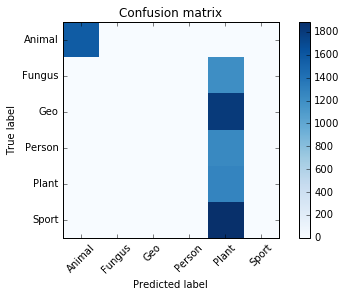

In [114]:
plt.figure()
plot_confusion_matrix(cm)

In [115]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.316123289196


In [ ]:
# animalPath = 'Data/Animal'
# fungusPath = 'Data/Fungus'
# geoPath = 'Data/Geological Formation'
# personPath = 'Data/Person'
# plantPath = 'Data/Plant, flora, plant life'
# sportPath = 'Data/Sport'

# color = 0
# # n00015388_24.JPEG

# img = Image.open(animalPath+'/'+"n00015388_12.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()

# img = Image.open(plantPath+'/'+"n00017222_16178.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()

# img = Image.open(plantPath+'/'+"n00017222_18453.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()

# img = Image.open(animalPath+'/'+"n00015388_1995.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()

# img = Image.open(geoPath+'/'+"n09287968_12782.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()

# img = Image.open(geoPath+'/'+"n09287968_2208.JPEG")
# img = img.resize(size_tup,Image.ANTIALIAS)
# np_img = np.asarray(img)
# r_img = np_img[:,:,color]
# plt.figure()
# plt.imshow(r_img)
# plt.plot()